In [609]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [610]:
data = pd.read_csv('stock_data.csv')
# data = data.iloc[:262, :]
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,5.398742,5.427103,5.368389,5.392273,141556000,0.0,0.0
1,5.389280,5.402725,4.988682,5.282470,1527812000,0.0,0.0
2,5.259566,5.700996,5.250852,5.576758,1561116000,0.0,0.0
3,5.624310,5.985073,5.596176,5.959678,2034124000,0.0,0.0
4,5.988310,6.020428,5.871044,5.897435,931420000,0.0,0.0
...,...,...,...,...,...,...,...
257,143.000000,143.139999,132.110001,135.399994,987765800,0.0,0.0
258,137.210007,149.770004,135.570007,147.630005,973098600,0.0,0.0
259,148.679993,149.649994,140.080002,141.979996,1017459800,0.0,0.0
260,139.500000,152.889999,137.149994,141.949997,1396925400,0.0,0.0


In [611]:
data['y'] = data['Close']

x = data.iloc[:, :7].values
y = data.iloc[:, 7].values
# x = data.iloc[:, :32].values
# y = data.iloc[:, 32].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (209, 7) trainY: (209,)
testX: (53, 7) testY: (53,)


In [612]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super().__init__()
        
        # Encoder
        self.encoder_layers = nn.ModuleList()
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            self.encoder_layers.append(
                nn.Sequential(
                    nn.Linear(current_dim, hidden_dim),
                    nn.ReLU()
                )
            )
            current_dim = hidden_dim
            
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])
        
        self.decoder_layers = nn.ModuleList()
        reversed_dims = list(reversed(hidden_dims))
        
        for i in range(len(reversed_dims) - 1):
            self.decoder_layers.append(
                nn.Sequential(
                    nn.Linear(reversed_dims[i], reversed_dims[i + 1]),
                    nn.ReLU()
                )
            )
            
        # Final output layer
        self.final_layer = nn.Sequential(
            nn.Linear(reversed_dims[-1], input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        for layer in self.encoder_layers:
            x = layer(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        for layer in self.decoder_layers:
            x = layer(x)
        return self.final_layer(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), z, mu, log_var

In [613]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
# first one must be the number of columns
model = VAE(input_dim=7, hidden_dims=[400, 400, 400,10], latent_dim=10)

In [614]:
num_epochs = 500
learning_rate = 0.00003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    loss_ = []
    for (x, ) in train_loader:
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print(f'[{epoch+1}/{num_epochs}] Loss:', sum(loss_))

[1/500] Loss: 33.31343173980713
[2/500] Loss: 33.122833251953125
[3/500] Loss: 33.029296875
[4/500] Loss: 32.94100284576416
[5/500] Loss: 32.853148460388184
[6/500] Loss: 32.767934799194336
[7/500] Loss: 32.685617446899414
[8/500] Loss: 32.61110782623291
[9/500] Loss: 32.546722412109375
[10/500] Loss: 32.49328136444092
[11/500] Loss: 32.45096206665039
[12/500] Loss: 32.42201614379883
[13/500] Loss: 32.403950691223145
[14/500] Loss: 32.39546775817871
[15/500] Loss: 32.393760681152344
[16/500] Loss: 32.39594268798828
[17/500] Loss: 32.393364906311035
[18/500] Loss: 32.38640594482422
[19/500] Loss: 32.374324798583984
[20/500] Loss: 32.3600549697876
[21/500] Loss: 32.342055320739746
[22/500] Loss: 32.31012535095215
[23/500] Loss: 32.265689849853516
[24/500] Loss: 32.20889854431152
[25/500] Loss: 32.142147064208984
[26/500] Loss: 32.07027339935303
[27/500] Loss: 31.991711616516113
[28/500] Loss: 31.91402244567871
[29/500] Loss: 31.834020614624023
[30/500] Loss: 31.75863552093506
[31/500] Lo

In [615]:
# model.eval()
# _, VAE_train_x, _, _ = model(torch.from_numpy(train_x_denoised).float().to(device))
# _, VAE_test_x, _, _ = model(torch.from_numpy(test_x_denoised).float().to(device))
model.eval()
_, VAE_train_x, _, _ = model(torch.from_numpy(train_x).float())
_, VAE_test_x, _, _ = model(torch.from_numpy(test_x).float())

In [616]:
def time_series_window(x, y, window_size):
    """
    Args:
        x: Input features array, shape (n_samples, n_features)
        y: Target values array, shape (n_samples, 1)
        window_size: Size of the sliding window
        
    Returns:
        tuple: (
            windowed_x: Feature windows, shape (n_samples-window, window_size, n_features)
            windowed_y: Single target values, shape (n_samples-window, 1)
            windowed_y_gan: Target windows, shape (n_samples-window, window_size+1, 1)
        )
    """
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    if not isinstance(y, np.ndarray):
        y = np.array(y)
        
    n_samples = len(x) - window_size
    
    windowed_x = np.zeros((n_samples, window_size, x.shape[1]))
    windowed_y = np.zeros((n_samples, 1))
    windowed_y_gan = np.zeros((n_samples, window_size + 1, 1))
    
    for i in range(n_samples):
        windowed_x[i] = x[i:i + window_size]
        windowed_y[i] = y[i + window_size]
        windowed_y_gan[i] = y[i:i + window_size + 1]
    
    return (torch.from_numpy(windowed_x).float(),
            torch.from_numpy(windowed_y).float(),
            torch.from_numpy(windowed_y_gan).float())

In [617]:
train_x_combined = np.concatenate((train_x, VAE_train_x.detach().numpy()), axis=1)
test_x_combined = np.concatenate((test_x, VAE_test_x.detach().numpy()), axis=1)

In [618]:
train_x_slide, train_y_slide, train_y_gan = time_series_window(train_x_combined, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = time_series_window(test_x_combined, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([206, 3, 17]) train_y: torch.Size([206, 1]) train_y_gan: torch.Size([206, 4, 1])
test_x: torch.Size([50, 3, 17]) test_y: torch.Size([50, 1]) test_y_gan: torch.Size([50, 4, 1])


In [619]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm_1 = nn.LSTM(input_size, 1024, batch_first=True)
        self.lstm_2 = nn.LSTM(1024, 512, batch_first=True)
        self.lstm_3 = nn.LSTM(512, 256, batch_first=True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        h0, c0 = (torch.zeros(1, x.size(0), 1024), torch.zeros(1, x.size(0), 1024))
        out_1, _ = self.lstm_1(x, (h0, c0))
        out_1 = self.dropout(out_1)

        h1, c1 = (torch.zeros(1, x.size(0), 512), torch.zeros(1, x.size(0), 512))
        out_2, _ = self.lstm_2(out_1, (h1, c1))
        out_2 = self.dropout(out_2)

        h2, c2 = (torch.zeros(1, x.size(0), 256), torch.zeros(1, x.size(0), 256))
        out_3, _ = self.lstm_3(out_2, (h2, c2))
        out_3 = self.dropout(out_3)

        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu')
        self.linear1 = nn.Linear(hidden_size, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size)
        rnn_out, _ = self.rnn(x, h0)
        out = rnn_out[:, -1, :]  # Get the last time step
        out_1 = self.linear1(out)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

# class Generator(nn.Module):
#     def __init__(self, input_size):
#         super().__init__()
#         self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
#         self.gru_2 = nn.GRU(1024, 512, batch_first = True)
#         self.gru_3 = nn.GRU(512, 256, batch_first = True)
#         self.linear_1 = nn.Linear(256, 128)
#         self.linear_2 = nn.Linear(128, 64)
#         self.linear_3 = nn.Linear(64, 1)
#         self.dropout = nn.Dropout(0.2)

#     def forward(self, x):
#         use_cuda = 1
#         device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
#         h0 = torch.zeros(1, x.size(0), 1024).to(device)
#         out_1, _ = self.gru_1(x, h0)
#         out_1 = self.dropout(out_1)
#         h1 = torch.zeros(1, x.size(0), 512).to(device)
#         out_2, _ = self.gru_2(out_1, h1)
#         out_2 = self.dropout(out_2)
#         h2 = torch.zeros(1, x.size(0), 256).to(device)
#         out_3, _ = self.gru_3(out_2, h2)
#         out_3 = self.dropout(out_3)
#         out_4 = self.linear_1(out_3[:, -1, :])
#         out_5 = self.linear_2(out_4)
#         out = self.linear_3(out_5)
#         return out

# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
#         self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
#         self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
#         self.linear1 = nn.Linear(128, 220)
#         self.batch1 = nn.BatchNorm1d(220)
#         self.linear2 = nn.Linear(220, 220)
#         self.batch2 = nn.BatchNorm1d(220)
#         self.linear3 = nn.Linear(220, 1)
#         self.leaky = nn.LeakyReLU(0.01)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         conv1 = self.conv1(x)
#         conv1 = self.leaky(conv1)
#         conv2 = self.conv2(conv1)
#         conv2 = self.leaky(conv2)
#         conv3 = self.conv3(conv2)
#         conv3 = self.leaky(conv3)
#         flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
#         out_1 = self.linear1(flatten_x)
#         out_1 = self.leaky(out_1)
#         out_2 = self.linear2(out_1)
#         out_2 = self.relu(out_2)
#         out_3 = self.linear3(out_2)
#         out = self.sigmoid(out_3)
#         return out

In [620]:
batch_size = 128
learning_rate = 0.00013
num_epochs = 150

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size=batch_size, shuffle=False)

modelG = Generator(17)
modelD = Discriminator()

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr=learning_rate, betas=(0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr=learning_rate, betas=(0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)

for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis=1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output)
        lossD_real = criterion(dis_real_output, real_labels)

        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/130] LossD: 2.774673819541931 LossG:1.422489583492279
[2/130] LossD: 2.772781014442444 LossG:1.4198358654975891
[3/130] LossD: 2.7712879180908203 LossG:1.4168335795402527
[4/130] LossD: 2.7700955867767334 LossG:1.414037048816681
[5/130] LossD: 2.7691885232925415 LossG:1.4111496806144714
[6/130] LossD: 2.7685511112213135 LossG:1.4082346558570862
[7/130] LossD: 2.768181324005127 LossG:1.4052727222442627
[8/130] LossD: 2.7683491706848145 LossG:1.4020476937294006
[9/130] LossD: 2.7694863080978394 LossG:1.398431420326233
[10/130] LossD: 2.7720766067504883 LossG:1.3940548300743103
[11/130] LossD: 2.77627170085907 LossG:1.3892539739608765
[12/130] LossD: 2.7793641090393066 LossG:1.3871002197265625
[13/130] LossD: 2.776902437210083 LossG:1.3898872137069702
[14/130] LossD: 2.7728841304779053 LossG:1.3931743502616882
[15/130] LossD: 2.7711639404296875 LossG:1.393224835395813
[16/130] LossD: 2.7711181640625 LossG:1.3916957378387451
[17/130] LossD: 2.7716715335845947 LossG:1.3901619911193848
[1

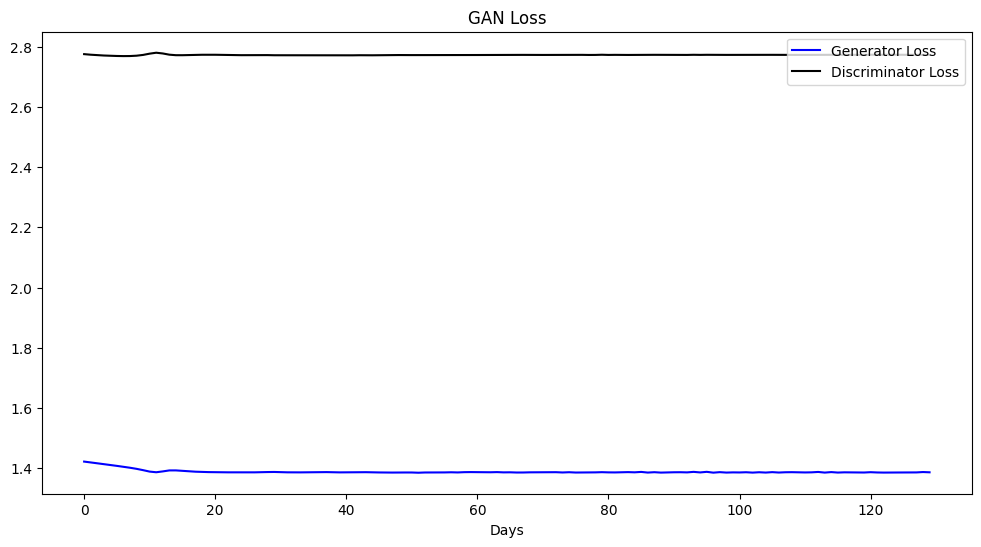

In [621]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [622]:
modelG.eval()
pred_y_train = modelG(train_x_slide)
pred_y_test = modelG(test_x_slide)

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.detach().numpy())

Training dataset RMSE:3.189718120869919


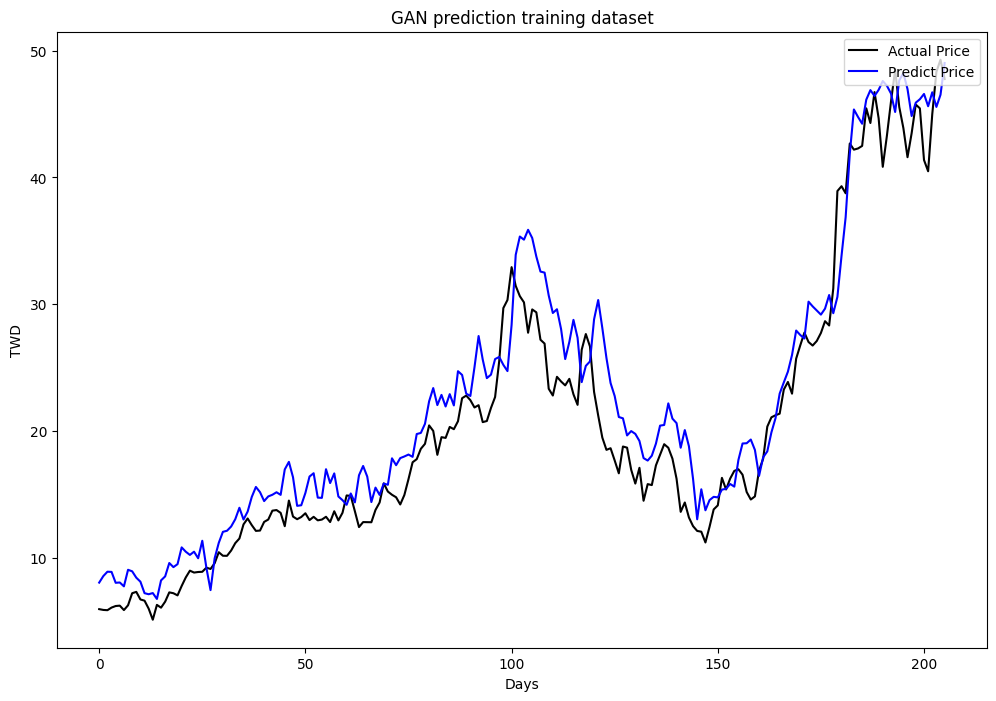

In [623]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Actual Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:27.79795985342975


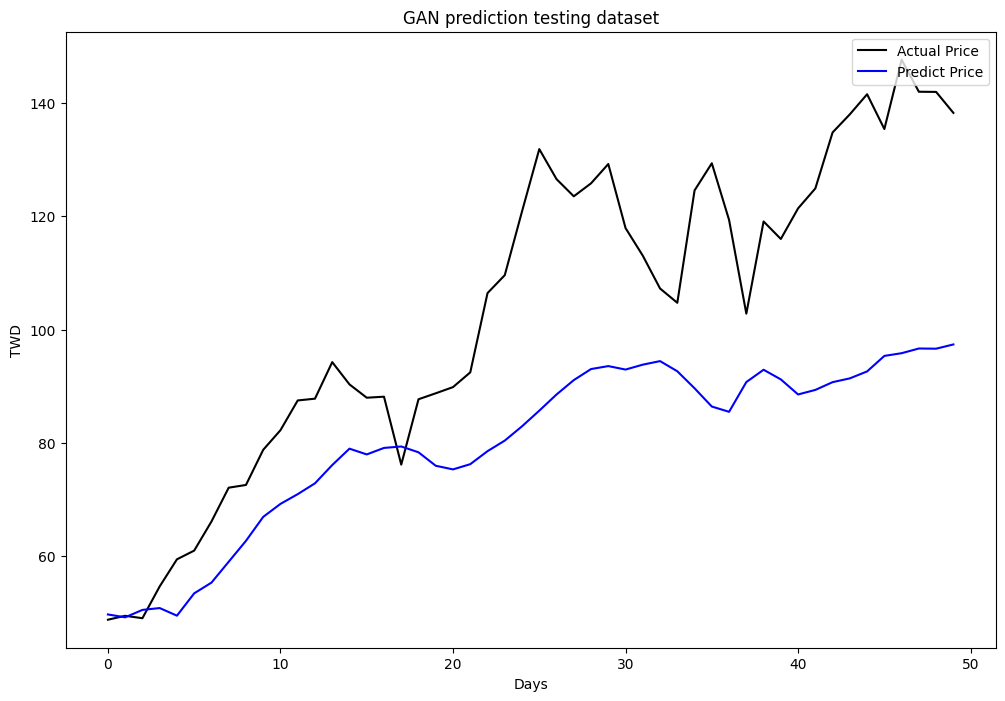

In [624]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Actual Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')